<a href="https://colab.research.google.com/github/ibader85/AdvancedAnalytics/blob/main/16_Natural_Language_Processing_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

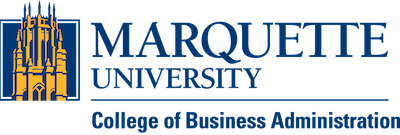

# BUAN 4061: Advanced Business Analytics
# Natural Language Processing 2

Instructor: Dr. Badar Al Lawati

**Acknowledgment**: This material is based on the content created by `Dr. Kambiz Saffarizadeh`

Credit: `Laurence Moroney` (https://github.com/lmoroney)



## Text Embeddings

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import numpy as np
import matplotlib.pyplot as plt

import json
from bs4 import BeautifulSoup
import string
from collections import OrderedDict

In [ ]:
stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at",
             "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do",
             "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having",
             "he", "hed", "hes", "her", "here", "heres", "hers", "herself", "him", "himself", "his", "how",
             "hows", "i", "id", "ill", "im", "ive", "if", "in", "into", "is", "it", "its", "itself",
             "lets", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought",
             "our", "ours", "ourselves", "out", "over", "own", "same", "she", "shed", "shell", "shes", "should",
             "so", "some", "such", "than", "that", "thats", "the", "their", "theirs", "them", "themselves", "then",
             "there", "theres", "these", "they", "theyd", "theyll", "theyre", "theyve", "this", "those", "through",
             "to", "too", "under", "until", "up", "very", "was", "we", "wed", "well", "were", "weve", "were",
             "what", "whats", "when", "whens", "where", "wheres", "which", "while", "who", "whos", "whom", "why",
             "whys", "with", "would", "you", "youd", "youll", "youre", "youve", "your", "yours", "yourself",
             "yourselves"]

table = str.maketrans('', '', string.punctuation)

## Data

In [ ]:
!wget https://raw.githubusercontent.com/ashwaniYDV/sarcasm-detection-tensorflow/main/sarcasm.json

--2024-04-04 18:48:20--  https://raw.githubusercontent.com/ashwaniYDV/sarcasm-detection-tensorflow/main/sarcasm.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5616834 (5.4M) [text/plain]
Saving to: ‘sarcasm.json’

sarcasm.json        100%[===================>]   5.36M  --.-KB/s    in 0.09s   

2024-04-04 18:48:21 (58.8 MB/s) - ‘sarcasm.json’ saved [5616834/5616834]



In [ ]:
with open("sarcasm.json", 'r') as f:
    datastore = json.load(f)

In [ ]:
datastore[0]

{'article_link': 'https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5',
 'headline': "former versace store clerk sues over secret 'black code' for minority shoppers",
 'is_sarcastic': 0}

In [ ]:
documents = []
labels = []
urls = []

for item in datastore:
    document = item['headline'].lower()
    document = document.replace(",", " , ")
    document = document.replace(".", " . ")
    document = document.replace("-", " - ")
    document = document.replace("/", " / ")
    soup = BeautifulSoup(document)
    document = soup.get_text()
    words = document.split()
    filtered_document = ""
    for word in words:
        word = word.translate(table)
        if word not in stopwords:
            filtered_document = filtered_document + word + " "
    documents.append(filtered_document)
    labels.append(item['is_sarcastic'])
    urls.append(item['article_link'])

<ipython-input-6-72ed67cae514>:11: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(document)


In [ ]:
documents[0]

'former versace store clerk sues secret black code minority shoppers '

## Vectorization

In [ ]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = ""
training_size = 23000

###Split the datasets into training and validation sets.

In [ ]:
training_docs = documents[0:training_size]
validation_docs = documents[training_size:]

training_labels = labels[0:training_size]
validation_labels = labels[training_size:]

### Tokenize the documents

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_docs)

word_index = tokenizer.word_index

### Sequence and pad the tokenized documents

In [ ]:
training_sequences = tokenizer.texts_to_sequences(training_docs)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

validation_sequences = tokenizer.texts_to_sequences(validation_docs)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

###Prepare the data for TensorFlow.

We need the following step to avoid the possible error of:

`Failed to find data adapter that can handle input: <class 'numpy.ndarray'>`

In [ ]:
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
validation_padded = np.array(validation_padded)
validation_labels = np.array(validation_labels)

## Model

In [ ]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

Note: `GlobalAveragePooling1D` is similar to `AveragePooling1D` with the main difference that `GlobalAveragePooling1D` takes the average among all steps. For instance, here, it takes the average of the `10,000` words for each of the `16` embedding dimensions leading to a total of `16` values out of the `160,000` parameters from the previous layer.

In [ ]:
model1.compile(loss='binary_crossentropy',
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
               metrics=['accuracy'])

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160433 (626.69 KB)
Trainable params: 160433 (626.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model1.fit(training_padded, training_labels, epochs = 100, validation_data=(validation_padded, validation_labels))

Epoch 1/100
719/719 [==============================] - 9s 8ms/step - loss: 0.6882 - accuracy: 0.5596 - val_loss: 0.6841 - val_accuracy: 0.5700
Epoch 2/100
719/719 [==============================] - 5s 6ms/step - loss: 0.6853 - accuracy: 0.5596 - val_loss: 0.6825 - val_accuracy: 0.5700
Epoch 3/100
719/719 [==============================] - 4s 5ms/step - loss: 0.6843 - accuracy: 0.5596 - val_loss: 0.6814 - val_accuracy: 0.5700
Epoch 4/100
719/719 [==============================] - 4s 5ms/step - loss: 0.6830 - accuracy: 0.5596 - val_loss: 0.6797 - val_accuracy: 0.5700
Epoch 5/100
719/719 [==============================] - 4s 6ms/step - loss: 0.6806 - accuracy: 0.5596 - val_loss: 0.6769 - val_accuracy: 0.5700
Epoch 6/100
719/719 [==============================] - 4s 5ms/step - loss: 0.6769 - accuracy: 0.5596 - val_loss: 0.6731 - val_accuracy: 0.5700
Epoch 7/100
719/719 [==============================] - 4s 5ms/step - loss: 0.6715 - accuracy: 0.5598 - val_loss: 0.6671 - val_accuracy: 0.5702

## Identifying Overfitting Issues

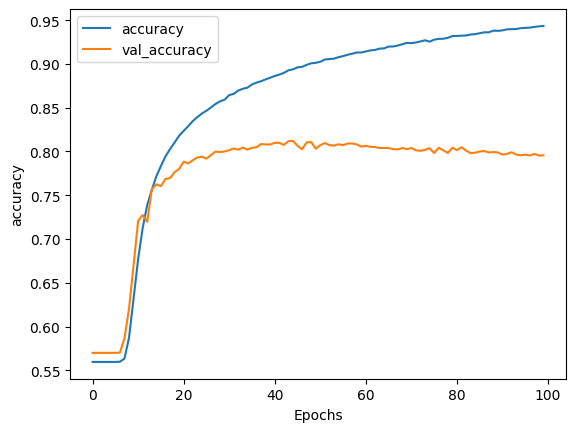

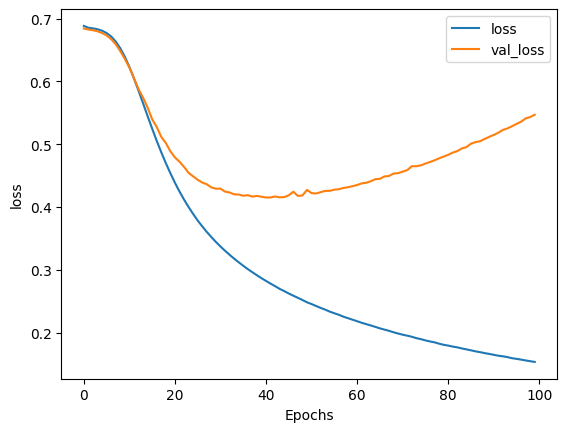

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

### Revised Model
Let's check the word count dictionary.

In [ ]:
wc = tokenizer.word_counts
print(wc)

OrderedDict([('former', 90), ('versace', 1), ('store', 44), ('clerk', 9), ('sues', 13), ('secret', 78), ('black', 230), ('code', 19), ('minority', 12), ('shoppers', 2), ('roseanne', 3), ('revival', 10), ('catches', 10), ('thorny', 3), ('political', 73), ('mood', 13), ('better', 100), ('worse', 34), ('mom', 163), ('starting', 37), ('fear', 39), ('sons', 35), ('web', 16), ('series', 53), ('closest', 5), ('thing', 126), ('will', 484), ('grandchild', 2), ('boehner', 26), ('just', 501), ('wants', 120), ('wife', 73), ('listen', 21), ('not', 634), ('come', 92), ('alternative', 13), ('debt', 23), ('reduction', 4), ('ideas', 35), ('j', 41), ('k', 39), ('rowling', 5), ('wishes', 33), ('snape', 2), ('happy', 51), ('birthday', 57), ('magical', 25), ('way', 239), ('advancing', 2), ('worlds', 79), ('women', 289), ('fascinating', 3), ('case', 77), ('eating', 64), ('lab', 8), ('grown', 17), ('meat', 25), ('ceo', 56), ('send', 33), ('kids', 164), ('school', 207), ('work', 168), ('company', 78), ('top',

We can sort this dictionary based on the frequency of words because it's an `OrderedDict`. By doing so, we can get a sense of how many words we need to include in our document vectors to decrease the amount of required computing resources and at the same time avoid overfitting.

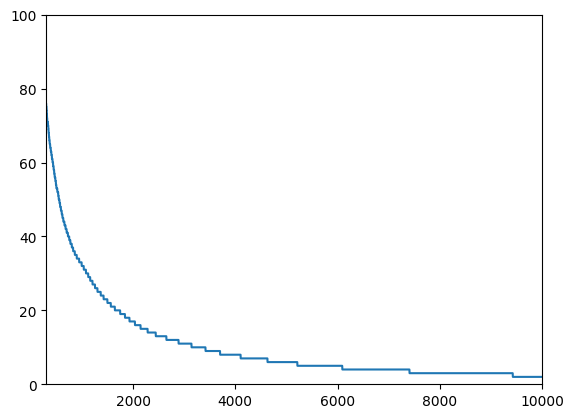

In [ ]:
newlist = (OrderedDict(sorted(wc.items(), key=lambda t: t[1], reverse=True)))

xs=[]
ys=[]
counter = 1
for item in newlist:
  xs.append(counter)
  counter = counter + 1
  ys.append(newlist[item])

plt.plot(xs,ys)
plt.axis([300,10000,0,100])
plt.show()

In [ ]:
vocab_size = 2000

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_docs)

training_sequences = tokenizer.texts_to_sequences(training_docs)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

validation_sequences = tokenizer.texts_to_sequences(validation_docs)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
validation_padded = np.array(validation_padded)
validation_labels = np.array(validation_labels)

We can also add a `Droupout` layer to reduce overfitting.

Also, we may have too many nodes in our Dense(24) layers. Instead we can change it to Dense(8). Best practice for embedding size is to have it be the fourth root of the vocab size.

In [ ]:
model2 = tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_size, embedding_dim),
  tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.Dense(8, activation='relu'),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model2.compile(loss='binary_crossentropy',
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
               metrics=['accuracy'])

In [ ]:
history2 = model2.fit(training_padded, training_labels, epochs = 100, validation_data=(validation_padded, validation_labels))

Epoch 1/100
719/719 [==============================] - 7s 8ms/step - loss: 0.6903 - accuracy: 0.5526 - val_loss: 0.6867 - val_accuracy: 0.5700
Epoch 2/100
719/719 [==============================] - 5s 7ms/step - loss: 0.6875 - accuracy: 0.5596 - val_loss: 0.6845 - val_accuracy: 0.5700
Epoch 3/100
719/719 [==============================] - 3s 4ms/step - loss: 0.6858 - accuracy: 0.5596 - val_loss: 0.6832 - val_accuracy: 0.5700
Epoch 4/100
719/719 [==============================] - 2s 3ms/step - loss: 0.6860 - accuracy: 0.5596 - val_loss: 0.6828 - val_accuracy: 0.5700
Epoch 5/100
719/719 [==============================] - 3s 5ms/step - loss: 0.6851 - accuracy: 0.5596 - val_loss: 0.6822 - val_accuracy: 0.5700
Epoch 6/100
719/719 [==============================] - 3s 4ms/step - loss: 0.6850 - accuracy: 0.5596 - val_loss: 0.6818 - val_accuracy: 0.5700
Epoch 7/100
719/719 [==============================] - 3s 3ms/step - loss: 0.6837 - accuracy: 0.5596 - val_loss: 0.6802 - val_accuracy: 0.5700

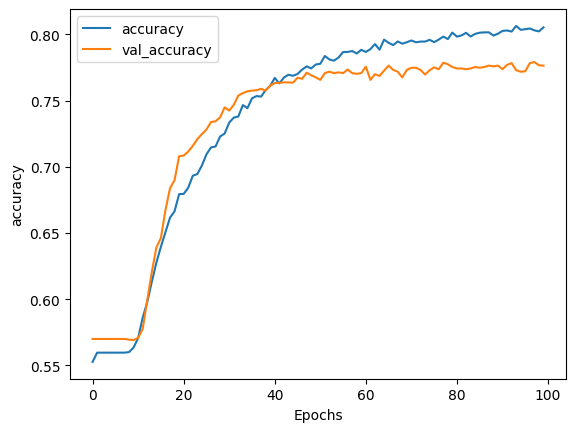

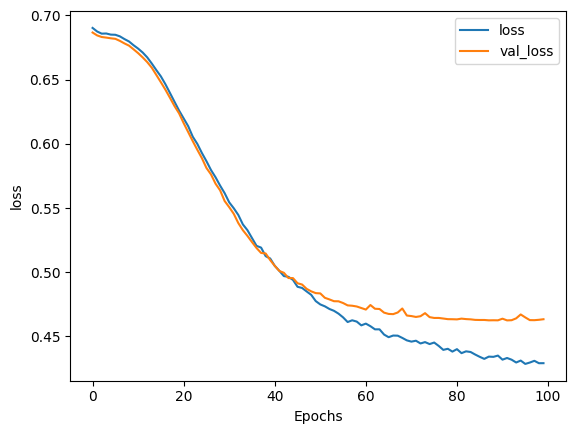

In [ ]:
plot_graphs(history2, "accuracy")
plot_graphs(history2, "loss")

###Instead of `Dropout()` we can use regularization.

- L1 regularization is often called lasso (least absolute shrinkage and selection operator) regularization. It effectively helps us ignore the zero or close-to-zero weights when calculating a result in a layer. https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/L1

- L2 regularization is often called ridge regression because it pushes values apart by taking their squares. This tends to amplify the differences between nonzero values and zero or close-to-zero ones, creating a ridge effect. https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/L2

In [ ]:
model3 = tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_size, embedding_dim),
  tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.Dense(8, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model3.compile(loss='binary_crossentropy',
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
               metrics=['accuracy'])

history3 = model3.fit(training_padded, training_labels, epochs = 100, validation_data=(validation_padded, validation_labels))

Epoch 1/100
719/719 [==============================] - 4s 5ms/step - loss: 0.7845 - accuracy: 0.5513 - val_loss: 0.7628 - val_accuracy: 0.5700
Epoch 2/100
719/719 [==============================] - 3s 5ms/step - loss: 0.7484 - accuracy: 0.5596 - val_loss: 0.7332 - val_accuracy: 0.5700
Epoch 3/100
719/719 [==============================] - 2s 3ms/step - loss: 0.7247 - accuracy: 0.5596 - val_loss: 0.7137 - val_accuracy: 0.5700
Epoch 4/100
719/719 [==============================] - 2s 3ms/step - loss: 0.7090 - accuracy: 0.5596 - val_loss: 0.7009 - val_accuracy: 0.5700
Epoch 5/100
719/719 [==============================] - 3s 4ms/step - loss: 0.6987 - accuracy: 0.5596 - val_loss: 0.6928 - val_accuracy: 0.5700
Epoch 6/100
719/719 [==============================] - 2s 3ms/step - loss: 0.6924 - accuracy: 0.5596 - val_loss: 0.6880 - val_accuracy: 0.5700
Epoch 7/100
719/719 [==============================] - 3s 4ms/step - loss: 0.6888 - accuracy: 0.5596 - val_loss: 0.6853 - val_accuracy: 0.5700

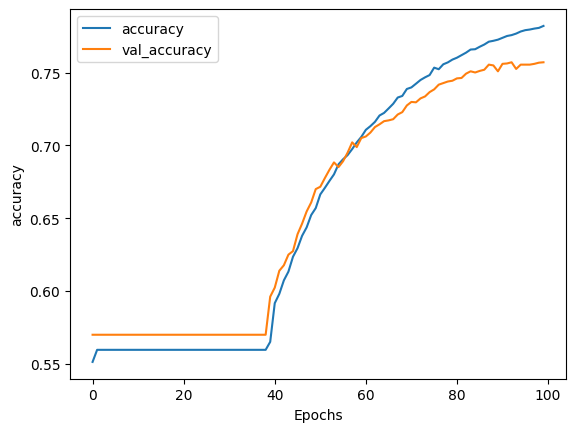

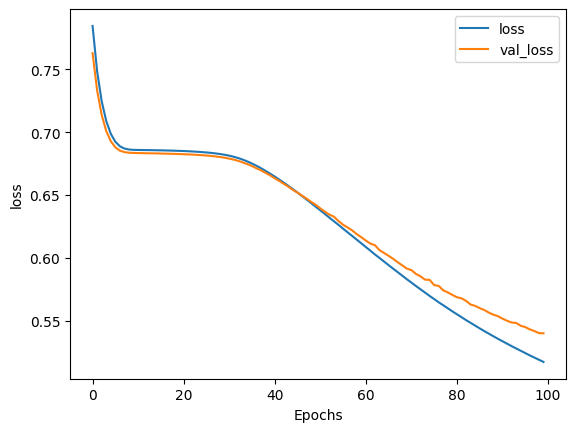

In [ ]:
plot_graphs(history3, "accuracy")
plot_graphs(history3, "loss")

##Use the Model

In [ ]:
sentences = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
model1.predict(padded)

1/1 [==============================] - 0s 135ms/step


array([[0.69833714],
       [0.01575658]], dtype=float32)

##Embeddings

Let's first create a reveres word index dictionary so that we can easily find the word associated with each index.

In [ ]:
reverse_word_index = {}

for (key, value) in word_index.items():
  reverse_word_index[value] = key

# Alternative code:
# reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

###Get the embeddings

In [ ]:
weights = model1.layers[0].get_weights()[0]

print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


In [ ]:
reverse_word_index[2]

'new'

In [ ]:
weights[0]

array([-0.10161561, -0.01497106,  0.11396585, -0.13240069,  0.00957934,
        0.0185053 , -0.11906514, -0.01310541,  0.02155253,  0.02977623,
        0.02904652, -0.14469473,  0.03592009, -0.01604033, -0.04421537,
        0.08138643], dtype=float32)